# Preparatory Work and Data Analysis

### 1)

### 2)

In [1]:
import numpy as np
import random

mu_1 = np.array([-3, 0])
mu_2 = np.array([3, 0])
sigma_1 = np.array([[5, -2], [-2, 1]])
sigma_2 = np.array([[5, 2], [2, 2]])

X = []
Y = []

# generate data of the desired distribution
for i in range(0,500):
    r = random.uniform(0, 1)
    if r < 0.3:
        x, y = np.random.multivariate_normal(mu_1, sigma_1)
    else:
        x, y = np.random.multivariate_normal(mu_2, sigma_2)
    X.append(x)
    Y.append(y)


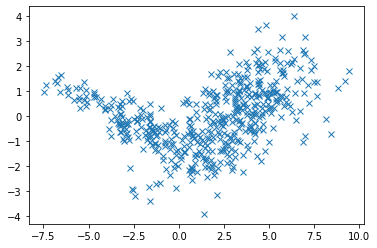

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(X, Y, 'x')
plt.show()

### 3)

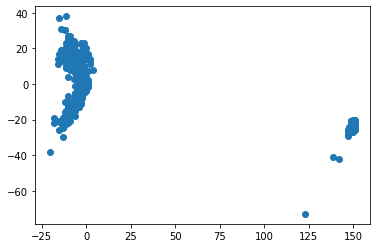

In [3]:
# reading the data and calculating the difference immediately

import pandas as pd

data = pd.read_csv('Unistroke/A01.txt', sep="\t", header=None).diff().iloc[1:]

for i in range(2,10):
    data = pd.concat([data, pd.read_csv('Unistroke/A0' + str(i) + '.txt', sep="\t", header=None).diff().iloc[1:]], ignore_index=True)
for i in range(10,51):
    data = pd.concat([data, pd.read_csv('Unistroke/A' + str(i) + '.txt', sep="\t", header=None).diff().iloc[1:]], ignore_index=True)

data.columns = ['x', 'y']
plt.scatter(data.x, data.y)

In [4]:
data2 = data.to_numpy()
data3 = np.copy(data2)

In [5]:
data2 == data3

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [5]:
data

,x,y
0,150.0,-21.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
958,-4.0,7.0
959,-2.0,3.0
960,1.0,-1.0
961,0.0,0.0


In [6]:
# normalizing the data
from timeit import default_timer as timer
start = timer()
for i in range(len(data2)):
    x = data2[i][0]
    y = data2[i][1]
    if x != 0 or y != 0:
        mag = np.sqrt(x**2 + y**2)
        data2[i][0] = x / mag
        data2[i][1] = y / mag
end = timer()
print(end - start)


# removing vector zero
data2 = data2[~np.all(data2 == 0, axis=1)]
data2

0.005005242999999382


array([[ 0.99034175, -0.13864784],
       [ 0.        , -1.        ],
       [-0.70710678, -0.70710678],
       ...,
       [-0.5547002 ,  0.83205029],
       [ 0.70710678, -0.70710678],
       [ 0.        ,  1.        ]])

In [9]:
# normalizing the data version 2.0
from timeit import default_timer as timer
start = timer()
rr = data3 ** 2
test = np.divide(data3, np.sqrt(rr[:, 0] + rr[:, 1]).reshape(-1, 1), where=data3 != 0)
end = timer()

print(end - start)
# removing vector zero
test = test[~np.all(test == 0, axis=1)]
test

0.0003322700000012446


array([[ 0.99034175, -0.13864784],
       [ 0.        , -1.        ],
       [-0.70710678, -0.70710678],
       ...,
       [-0.5547002 ,  0.83205029],
       [ 0.70710678, -0.70710678],
       [ 0.        ,  1.        ]])

In [10]:
test == data2


array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

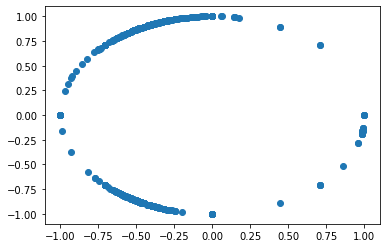

In [11]:
# plotting the normalized vectors

plt.scatter(data2[:,0], data2[:,1])

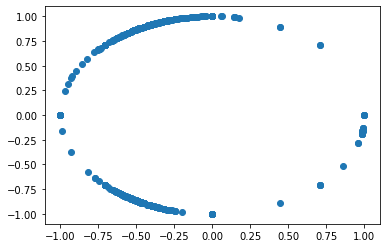

In [12]:
# plotting the normalized vectors version 2.0

plt.scatter(test[:,0], test[:,1])

In [143]:
from sklearn.mixture import GaussianMixture


model = GaussianMixture(n_components=2,  n_init = 10)

In [144]:
# fitting a two component GMM

y = model.fit_predict(data2)

In [145]:
print(model.n_iter_)
print(model.weights_)
print(model.converged_)

5
[0.52639398 0.47360602]
True


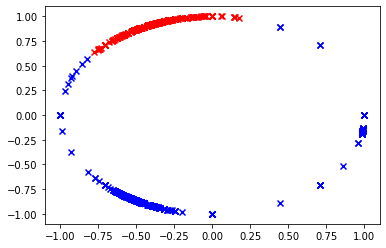

In [146]:
# splitting the data into different subgroups depending on the predicted class.
# Here the code works whether n_components = 2 or 3

x1 = []
y1 = []
x2 = []
y2 = []
x3 = []
y3 = []

for i in range(len(data2)):
    if y[i] == 0:
        x1.append(data2[i][0])
        y1.append(data2[i][1])
    elif y[i] == 1:
        x2.append(data2[i][0])
        y2.append(data2[i][1])
    else:
        x3.append(data2[i][0])
        y3.append(data2[i][1])
        
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x1, y1, c='b', marker="x")
ax1.scatter(x2, y2, c='r', marker="x")
ax1.scatter(x3, y3, c='k', marker="x")


plt.show()

### Let's try some model selection
Reference: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

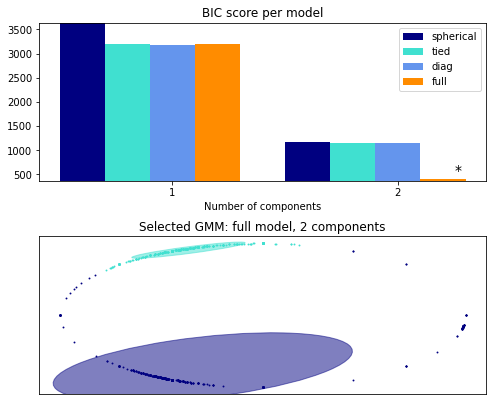

In [142]:
import itertools

from scipy import linalg
import matplotlib as mpl


X = np.copy(data2)

lowest_bic = np.infty
bic = []
n_components_range = range(1, 3)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type, n_init=10)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            best_cv = cv_type
            best_ncomponents = n_components

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(f'Selected GMM: {best_cv} model, {best_ncomponents} components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

It appears covariance matrix of type full is the best choice for our data. I noticed that adding more components gives better(i.e. lower) BIC scores but they become negative. No idea if that's good or bad. Anyway, we were told to fit a mixture with 2 components.

### 2)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Log scale: values of z <= 0 have been masked
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


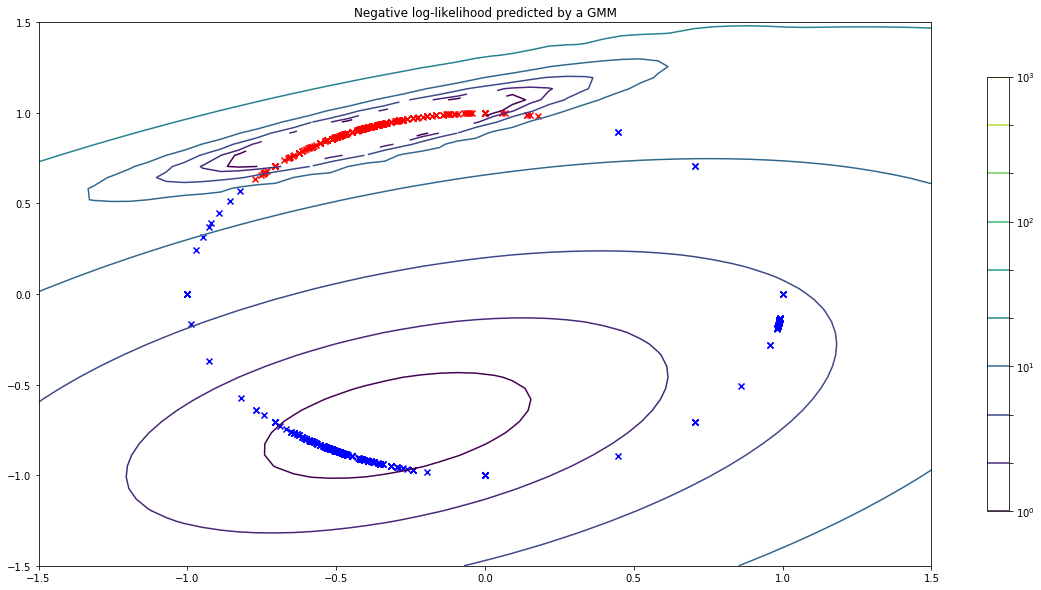

In [16]:
# plotting the contours of the log likelihood of the gmm


from matplotlib.colors import LogNorm
X_train = data2
clf = model

# display predicted scores by the model as a contour plot
x = np.linspace(-1.5, 1.5)
y = np.linspace(-1.5, 1.5)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

fig, ax = plt.subplots(figsize=(20, 10))

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
ax.scatter(x1, y1, c='b', marker="x")
ax.scatter(x2, y2, c='r', marker="x")
ax.scatter(x3, y3, c='k', marker="x")
plt.title('Negative log-likelihood predicted by a GMM')
ax.axis('tight')
fig.show()

### 3)

/home/hd/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(array([0.14013453, 0.44843049, 2.44394619, 1.01457399, 0.16816143,
        0.42600897, 0.        , 0.01681614, 0.03363229, 0.30829596]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

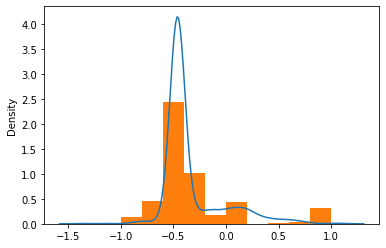

In [20]:
import seaborn as sns

all_x = []
all_y = []

for x_i , y_i in data2:
    all_x.append(x_i)
    all_y.append(y_i)

# fitting a univariate gmm on x-coordinates only
model_x = GaussianMixture(n_components=2)
model_x_pred = model_x.fit_predict(np.array(all_x).reshape(-1,1))
# extracting the parameters
weights = model_x.weights_
mu = model_x.means_
sigma = model_x.covariances_

samples_x = []
# generating random data according to the distribution to plot it
for i in range(0, 1000):
    if random.uniform(0, 1) < weights[0]:
        z = 0
    else:
        z = 1
    samples_x.append(np.random.normal(mu[z], sigma[z], 1))

# plot the predicted distribution curve along with the histogram of the x-coordinates
sns.distplot(samples_x, hist=False)

plt.hist(all_x, density=True)


/home/hd/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(array([1.89461883, 0.2690583 , 0.01121076, 0.01681614, 0.2690583 ,
        0.11210762, 0.02242152, 0.01681614, 0.25784753, 2.13004484]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

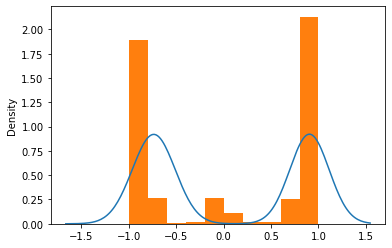

In [21]:
# SAME BUT FOR Y-COORDINATES

model_y = GaussianMixture(n_components=2)
model_y_pred = model_y.fit_predict(np.array(all_y).reshape(-1,1))

weights = model_y.weights_
mu = model_y.means_
sigma = model_y.covariances_

samples_y = []
for i in range(0, 1000):
    if random.uniform(0, 1) < weights[0]:
        z = 0
    else:
        z = 1
    samples_y.append(np.random.normal(mu[z], sigma[z], 1))

sns.distplot(samples_y, hist=False)

plt.hist(all_y, density=True)


/home/hd/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(array([0.26595745, 0.38297872, 2.87234043, 0.53191489, 0.0106383 ,
        0.25531915, 0.        , 0.03191489, 0.06382979, 0.58510638]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

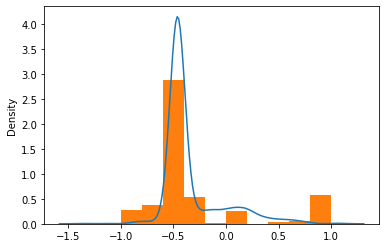

In [22]:
# plotting the histogram of x-coordinates of the FIRST CLASS against the univariate distr

sns.distplot(samples_x, hist=False)
plt.hist(x1, density=True)

/home/hd/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(array([0.69634482, 0.49738916, 1.0693867 , 3.23302954, 2.28799014,
        0.69634482, 0.49738916, 0.22382512, 1.19373399, 0.09947783]),
 array([-0.7739573 , -0.67867303, -0.58338875, -0.48810448, -0.3928202 ,
        -0.29753593, -0.20225166, -0.10696738, -0.01168311,  0.08360116,
         0.17888544]),
 <a list of 10 Patch objects>)

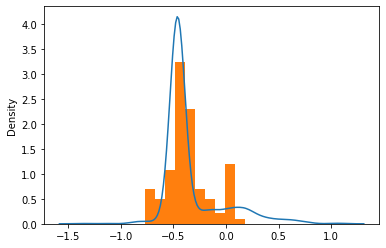

In [23]:
# plotting the x coordinates of the SECOND CLASS against the univariate distr

sns.distplot(samples_x, hist=False)
plt.hist(x2, density=True)

/home/hd/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(array([3.72874176, 0.60648209, 0.0224623 , 0.03369345, 0.53909519,
        0.224623  , 0.0224623 , 0.0449246 , 0.01123115, 0.0449246 ]),
 array([-1.        , -0.81055728, -0.62111456, -0.43167184, -0.24222912,
        -0.0527864 ,  0.13665631,  0.32609903,  0.51554175,  0.70498447,
         0.89442719]),
 <a list of 10 Patch objects>)

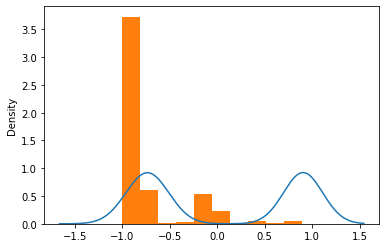

In [24]:
# plotting the Y-COORDINATES of the FIRST CLASS against the univariate distr

sns.distplot(samples_y, hist=False)
plt.hist(y1, density=True)

/home/hd/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(array([0.3230524 , 0.12922096, 1.42143056, 0.38766288, 1.09837816,
        1.35682008, 2.2613668 , 7.75325762, 6.52565849, 6.00877465]),
 array([0.63323779, 0.66991401, 0.70659023, 0.74326645, 0.77994267,
        0.8166189 , 0.85329512, 0.88997134, 0.92664756, 0.96332378,
        1.        ]),
 <a list of 10 Patch objects>)

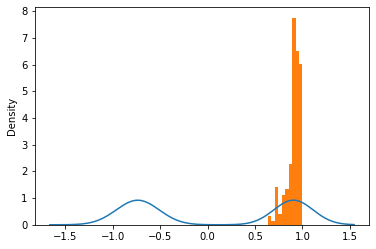

In [25]:
# plotting the Y-COORDINATES of the SECOND CLASS against the univariate distr


sns.distplot(samples_y, hist=False)
plt.hist(y2, density=True)

### 4)

Using a bivariate GMM is valid, as the univariate one fails to capture the "natural" clustering of the data. The predicted distribution doesn't exactly conform with the shape of the histograms.

###  5)

Isn't this already done in the contours?

- I think he wants us to do something like colour mixing to show the mixing of responsibilities of each component for each data point.


References:
- [https://matplotlib.org/tutorials/colors/colormap-manipulation.html](https://matplotlib.org/tutorials/colors/colormap-manipulation.html)
- [https://matplotlib.org/tutorials/colors/colormaps.html](https://matplotlib.org/tutorials/colors/colormaps.html)

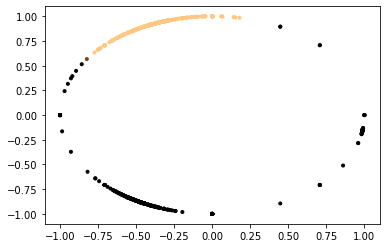

In [69]:
from matplotlib import cm

# get posterior probabilities to be used as input to color_map functions
P_Z = model.predict_proba(data2) 
color_map = cm.get_cmap('copper')
colors = [color_map(x) for x in P_Z[:, 0]]

plt.scatter(data2[:,0], data2[:,1], c=colors, marker='.')

The plot can be interpreted as showing how much mixing of the two Guasssian components occurs for each data point. For the color map we've defined, the black colored points correspond to points where the first component takes a very high responsibility while the light brown colored points correspond to those for the second component. We can observe a brown data point which indicates that the two components do not have as high responsibilities in this case. Said differently, the data point is generated by a stronger mix of the two mixture components than as seen with other points.

# Mandatory Work
### 1)

(array([0.01099447, 0.64867377, 0.04397788, 0.01099447, 0.09895024,
        0.        , 0.00732965, 0.27852659, 0.49475118, 0.04031306]),
 array([-2.97644398, -2.36464031, -1.75283665, -1.14103299, -0.52922932,
         0.08257434,  0.694378  ,  1.30618166,  1.91798533,  2.52978899,
         3.14159265]),
 <a list of 10 Patch objects>)

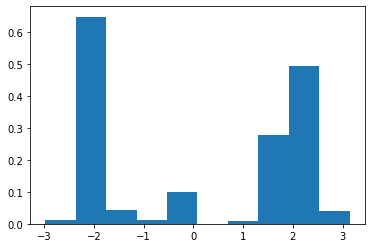

In [12]:
# calculating the angles and plotting their histogram

angles = np.arctan2(data2[:,1], data2[:,0])
plt.hist(angles, density=True)

### 2)

Mixture of von-Mises to be defined

### 3)

Answer should be something like: Yes, we have directional data which is more suited to a directional distribution like the von-Mises distribution

### 4)

To be done
References:
- [Clustering on the Unit Hypersphere usingvon Mises-Fisher Distributions](https://www.jmlr.org/papers/volume6/banerjee05a/banerjee05a.pdf)
- [Directional Statistics in Machine Learning: a Brief Review](https://arxiv.org/pdf/1605.00316.pdf)

### 5)

In [28]:
# CODE FOR VON MISES DISTRIBUTION COPIED FROM 
# https://framagit.org/fraschelle/mixture-of-von-mises-distributions/-/tree/master


from scipy.special import iv
from scipy.optimize import fsolve

def vonmises_density(x,mu,kappa):
    """
    Calculate the von Mises density for a series x (a 1D numpy.array).
    Input : 
        x : a 1D numpy.array of size L
        mu : a 1D numpy.array of size n, the mean of the von Mises distributions
        kappa : a 1D numpy.array of size n, the dispersion of the von Mises distributions
    Output : 
        a (L x n) numpy array, L is the length of the series, and n is the size of the array containing the parameters. Each row of the output corresponds to a density
    """
    res = []
    for i in x:
        f = np.exp(kappa*np.cos(i-mu))
        n = 2*np.pi*iv(0,kappa)
        res.append(f/n)
    return(np.array(res))

def vonmises_pdfit(series):
    """
    Calculate the estimator of the mean and deviation of a sample, for a von Mises distribution
    Input : 
        series : a 1D numpy.array
    Output : 
        the estimators of the parameters mu and kappa of a von Mises distribution, in an list [mu, kappa]
    See https://en.wikipedia.org/wiki/Von_Mises_distribution 
    for more details on the von Mises distribution
    """
    s0 = np.mean(np.sin(series))
    c0 = np.mean(np.cos(series))
    mu = np.arctan2(s0,c0)
    var = 1-np.sqrt(s0**2+c0**2)
    k = lambda kappa: 1-iv(1,kappa)/iv(0,kappa)-var
    kappa = fsolve(k, 0.0)[0]
    return([mu,kappa])

def mixture_vonmises_pdfit(series, n=2, threshold=1e-3):
    """
    Find the parameters of a mixture of von Mises distributions, using an EM algorithm.
    Input : 
        series : a 1D numpy array, representing the stochastic perdioci process
        n : an int, the number of von Mises distributions in th emixture
        threshold : a float, correspond to the euclidean distance between the old parameters and the new ones
    Output : a (3 x n) numpy-array, containing the probability amplitude of the distribution, and the mu and kappa parameters on each line.
    """
    # initialise the parameters and the distributions
    pi = np.random.random(n)
    mu = np.random.vonmises(0.0,0.0,n)
    kappa = np.random.random(n)
    t = pi*vonmises_density(series,mu,kappa)
    s = np.sum(t, axis=1)
    t = (t.T/s).T
    thresh = 1.0
    # calculate and update the coefficients, untill convergence
    while thresh > threshold:
        new_pi = np.mean(t, axis=0)
        new_mu = np.arctan2(np.sin(series)@t,np.cos(series)@t)      
        c = np.cos(series)@(t*np.cos(new_mu))+np.sin(series)@(t*np.sin(new_mu))
        k = lambda kappa: (c-iv(1,kappa)/iv(0,kappa)*np.sum(t, axis=0)).reshape(n)
        new_kappa = fsolve(k, np.zeros(n))
        thresh = np.sum((pi-new_pi)**2+(mu-new_mu)**2+(kappa-new_kappa)**2)
        pi = new_pi
        mu = new_mu
        kappa = new_kappa
        t = pi*vonmises_density(series,mu,kappa)
        s = np.sum(t, axis=1)
        t = (t.T/s).T
    res = np.array([pi,mu,kappa])
    # in case there is no mixture, one fits the data using the estimators
    if n == 1:
        res = vonmises_pdfit(series)
        res = np.append(1.0,res)
        res = res.reshape(3,1)
    return(res)


In [29]:
m = mixture_vonmises_pdfit(angles,n=2)
m

array([[  0.61760991,   0.38239009],
       [  1.93142736,  -2.07927965],
       [  1.77663122, 102.97554197]])

In [32]:
# plot the empirical distribution
h = np.histogram(angles, bins=55)
h_norm = np.array(h[0])/np.sum(h[0])
t = [np.mean(h[1][i:i+2]) for i in range(len(h[1])-1)]
#plt.plot(t,h_norm)
# plot the distribution using the parameters obtained from the EM algorithm
f = np.zeros(len(t))
for i in range(m.shape[1]):
    f += m[0,i]*vonmises_density(t,m[1,i],m[2,i])
plt.plot(t,f/np.sum(f))
plt.hist(angles, density=True)

TypeError: _histogram_dispatcher() got an unexpected keyword argument 'n_bins'

### Fitting a mixture of von Mises distributions

Code in the following sections depends on the library: [spherecluster](https://github.com/jasonlaska/spherecluster)

Installation can be done in two ways as described in the linked repo. If you choose to install from PyPI by `pip install spherecluster`, you might run into an error `ImportError: cannot import name '_k_means' from 'sklearn.cluster'`. To fix this, you have to downgrade your scikit-learn to version 0.22.0 e.g. by running `conda install scikit-learn=0.22.0`.

However, cloning the repository and installing with the develop branch fixes this issue. For more details, see this closed issue [ImportError: cannot import name '\_k\_means' #26](https://github.com/jasonlaska/spherecluster/issues/26)



In [65]:
from spherecluster import VonMisesFisherMixture

movm = VonMisesFisherMixture(n_clusters=2, posterior_type='soft')
movm.fit(test) # note the library expects data in the form of normalized vectors, not angles

print('Estimated parameters',
      '===========================================================',
      f'Means/Positions: {movm.cluster_centers_}',
      f'Concentrations: {movm.concentrations_}',
      f'Weights: {movm.weights_}',
      sep='\n')


Estimated parameters
Means/Positions: [[-0.38281451 -0.92382523]
 [-0.37331669  0.92770397]]
Concentrations: [ 2.71079124 22.07092627]
Weights: [0.52938759 0.47061241]


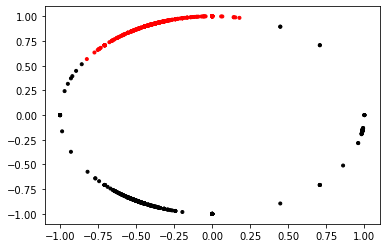

In [66]:
colors = ['r' if label == 1 else 'k' for label in movm.labels_]

plt.scatter(test[:,0], test[:,1], c=colors, marker='.')